<a href="https://colab.research.google.com/github/MalayaRP/Drug-Discovery/blob/main/Reg_DeepChem_GCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit-pypi

     |████████████████████████████████| 22.7 MB 1.5 MB/s 


In [ ]:
pip install --pre deepchem[torch]

     |████████████████████████████████| 608 kB 4.3 MB/s 
     |████████████████████████████████| 138 kB 44.9 MB/s 
     |████████████████████████████████| 4.4 MB 41.2 MB/s 
  Created wheel for dgllife: filename=dgllife-0.2.9-py3-none-any.whl size=219056 sha256=711c1139e25cd7830124b6673771d8f1dacdbe0de4ad40b28fe41eca0e256b6e
  Stored in directory: /root/.cache/pip/wheels/34/83/11/9772c74b559d9182c9083362e8ba8b0201c4963e41e03859fe
Successfully built dgllife


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage
import deepchem as dc

In [ ]:

!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2022-05-21 08:09:39--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.02s   

2022-05-21 08:09:40 (5.27 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [ ]:
!pip install deepchem

In [ ]:
from deepchem.utils.save import load_from_disk

dataset_file= "delaney-processed.csv"
dataset = load_from_disk(dataset_file)

deepchem.utils.save has been deprecated.
The utilities in save.py are moved to deepchem.utils.data_utils or deepchem.utils.genomics_utils.


In [ ]:
print(dataset.columns.values)

['Compound ID' 'ESOL predicted log solubility in mols per litre'
 'Minimum Degree' 'Molecular Weight' 'Number of H-Bond Donors'
 'Number of Rings' 'Number of Rotatable Bonds' 'Polar Surface Area'
 'measured log solubility in mols per litre' 'smiles']


In [ ]:
dataset.shape[0]
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
dataset["measured log solubility in mols per litre"]

0      -0.770
1      -3.300
2      -2.060
3      -7.870
4      -1.330
        ...  
1123   -1.710
1124    0.106
1125   -3.091
1126   -3.180
1127   -4.522
Name: measured log solubility in mols per litre, Length: 1128, dtype: float64

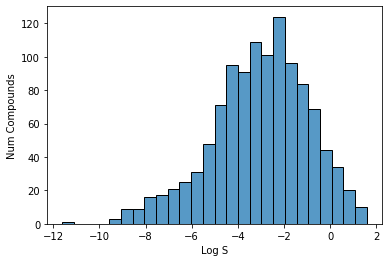

In [ ]:
plt.ylabel("Num Compounds")
plt.xlabel("Log S")
sns.histplot(dataset["measured log solubility in mols per litre"])

In [ ]:
import deepchem as dc

featurizer = dc.feat.ConvMolFeaturizer()

In [ ]:
# featurizer

In [ ]:
loader = dc.data.CSVLoader(
      tasks=["measured log solubility in mols per litre"], smiles_field="smiles",
      featurizer=featurizer)
dataset = loader.featurize(dataset_file)
dataset

smiles_field is deprecated and will be removed in a future version of DeepChem.Use feature_field instead.
/usr/local/lib/python3.7/dist-packages/deepchem/data/data_loader.py:163: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


<DiskDataset X.shape: (1128,), y.shape: (1128, 1), w.shape: (1128, 1), task_names: ['measured log solubility in mols per litre']>

In [ ]:
dataset.ids

array(['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ',
       'Cc1occc1C(=O)Nc2ccccc2', 'CC(C)=CCCC(C)=CC(=O)', ...,
       'CCSCCSP(=S)(OC)OC', 'CCC(C)C',
       'COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl'], dtype=object)

In [ ]:
splitter = dc.splits.ScaffoldSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)

In [ ]:
test_dataset.

<DiskDataset X.shape: (113,), y.shape: (113, 1), w.shape: (113, 1), ids: ['c1cc2ccc3cccc4ccc(c1)c2c34' 'Cc1cc(=O)[nH]c(=S)[nH]1'
 'Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 ' ...
 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43' 'Cc1occc1C(=O)Nc2ccccc2'
 'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '], task_names: ['measured log solubility in mols per litre']>

In [ ]:
train_mols = [Chem.MolFromSmiles(compound)
              for compound in train_dataset.ids]

In [ ]:
## transformers is used to normalise the data
transformers = [dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

In [ ]:
from deepchem.models.layers import GraphPool, GraphGather

In [ ]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)
model.fit(train_dataset, nb_epoch=100)

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("train: ",model.evaluate(train_dataset, [metric], transformers))
print("test: ",model.evaluate(test_dataset, [metric], transformers))

train:  {'pearson_r2_score': 0.911555213211349}
test:  {'pearson_r2_score': 0.7104760150827695}


In [ ]:
smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
'CCOC(=O)CC',
'CSc1nc(NC(C)C)nc(NC(C)C)n1',
'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
'Cc1cc2ccccc2cc1C']

In [ ]:
from rdkit import Chem
mols = [Chem.MolFromSmiles(s) for s in smiles]
featurizer = dc.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)
predicted_solubility = model.predict_on_batch(x)
predicted_solubility

array([[-4.6868734 ],
       [ 0.66065794],
       [-2.1532826 ],
       [-3.8575907 ],
       [-3.5967016 ]], dtype=float32)